# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name(s): Nipun Waas

Student number(s): 2305414

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [1]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enter data folder location
loc = "./MEx"

In [2]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)
    
    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df
    
    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,03,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...
2,03,06,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,03,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,03,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


In [3]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.
    
for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())
    
    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue
        
        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()
        
        records_windowed.append(tmp_data)
        
df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,03,02,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,03,02,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,03,02,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,03,02,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

In [4]:
df_records_windowed_vis = deepcopy(df_records_windowed)

acc_data = df_records_windowed_vis[df_records_windowed_vis['sensor'] == 'acc']
dc_data = df_records_windowed_vis[df_records_windowed_vis['sensor'] == 'dc']

## Accelerometer Data Visualization

This code randomly selects and plots accelerometer data from three samples (`random_samples`). It accumulates DataFrames and titles, then uses `plot_accelerometer_components_list` to visualize the data in a single row. Ensure `acc_data` is loaded before running.


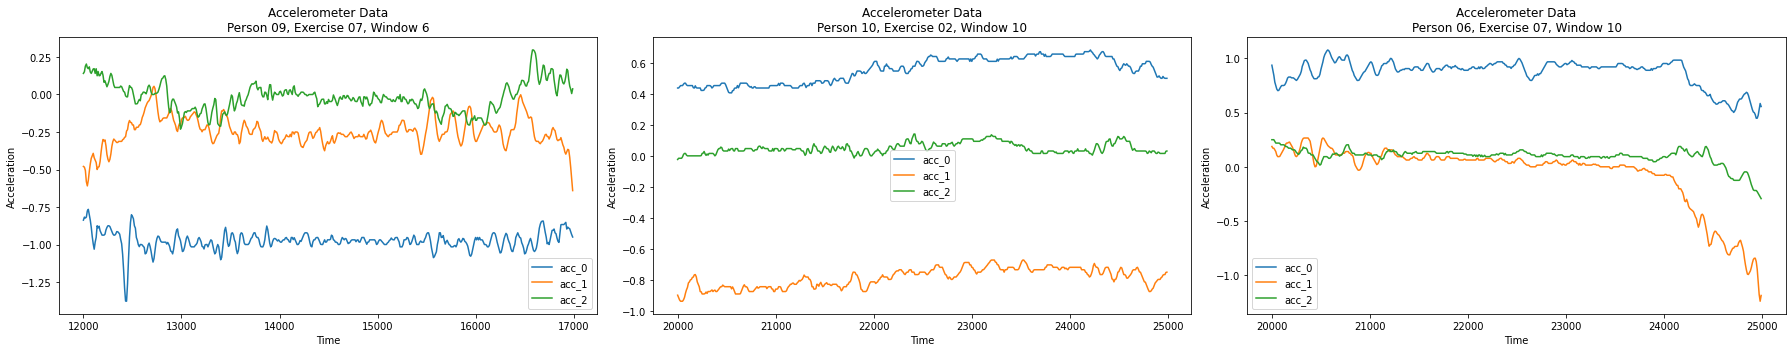

In [5]:
def plot_accelerometer_components_list(df_list, components=['acc_0', 'acc_1', 'acc_2'], titles=None):
    """
    Plots the accelerometer components from a list of dataframes.

    Parameters:
    - df_list (list): A list of pandas DataFrames containing accelerometer data.
    - components (list): A list of strings specifying the accelerometer components to plot. Default is ['acc_0', 'acc_1', 'acc_2'].
    - titles (list): A list of strings specifying the titles for each plot. If not provided, default titles will be generated.

    Returns:
    - None
    """
    
    num_plots = len(df_list)

    # If titles are not provided, generate default titles
    if titles is None:
        titles = [f'Plot {i+1}' for i in range(num_plots)]

    # Plotting each accelerometer data in the same row
    fig, axs = plt.subplots(1, num_plots, figsize=(25, 5))
    for i, (df, title) in enumerate(zip(df_list, titles)):
        axs[i].set_title(title)
        for component in components:
            axs[i].plot(df['time'], df[component], label=component)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Acceleration')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

random_samples = acc_data.sample(3, random_state=42)

# Accumulate DataFrames from random_samples
acc_list = [row['df'] for _, row in random_samples.iterrows()]

# Accumulate titles for each DataFrame
titles_list = [f'Accelerometer Data\nPerson {row["subject_id"]}, Exercise {row["exercise_id"]}, Window {row["window_idx"]}' for index, row in random_samples.iterrows()]

# Plotting all accumulated accelerometer data in the same row
plot_accelerometer_components_list(acc_list, components=['acc_0', 'acc_1', 'acc_2'], titles=titles_list)

Plot of 5 second acceleration sensor sequences of person 1 and 5 performing exercises 2, 5, and 6

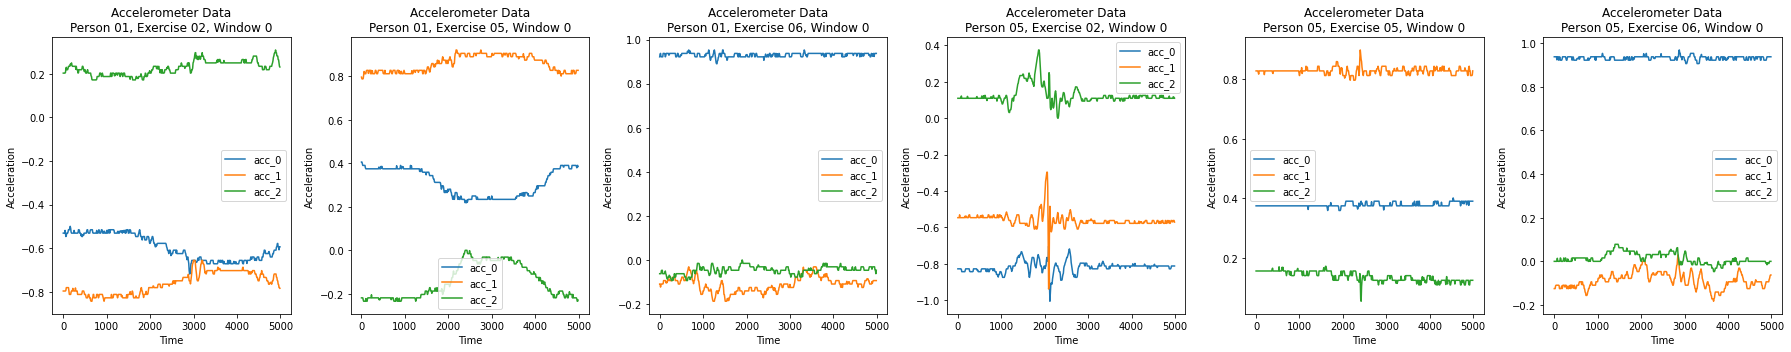

In [6]:
subject_id = ['01', '05']
exercise_id = ['02', '05', '06']
data_to_plot = []
for subject in subject_id:
    for exercise in exercise_id:
        data_to_plot.append(acc_data[(acc_data['subject_id'] == subject) & (acc_data['exercise_id'] == exercise)].iloc[0])

acc_list = [row['df'] for row in data_to_plot]
titles_list = [f'Accelerometer Data\nPerson {row["subject_id"]}, Exercise {row["exercise_id"]}, Window {row["window_idx"]}' for row in data_to_plot]

plot_accelerometer_components_list(acc_list, components=['acc_0', 'acc_1', 'acc_2'], titles=titles_list)

## Depth Camera Visualization

This cell generates and visualizes depth camera data for three different windows. The code extracts and preprocesses depth camera data from `dc_data` for 3 windows. It then uses the `plot_dc_values` function to create subplots for each window, providing a quick overview of the depth camera data.

**Instructions:**
- Ensure the `dc_data` DataFrame is loaded and necessary libraries are imported before running this cell.


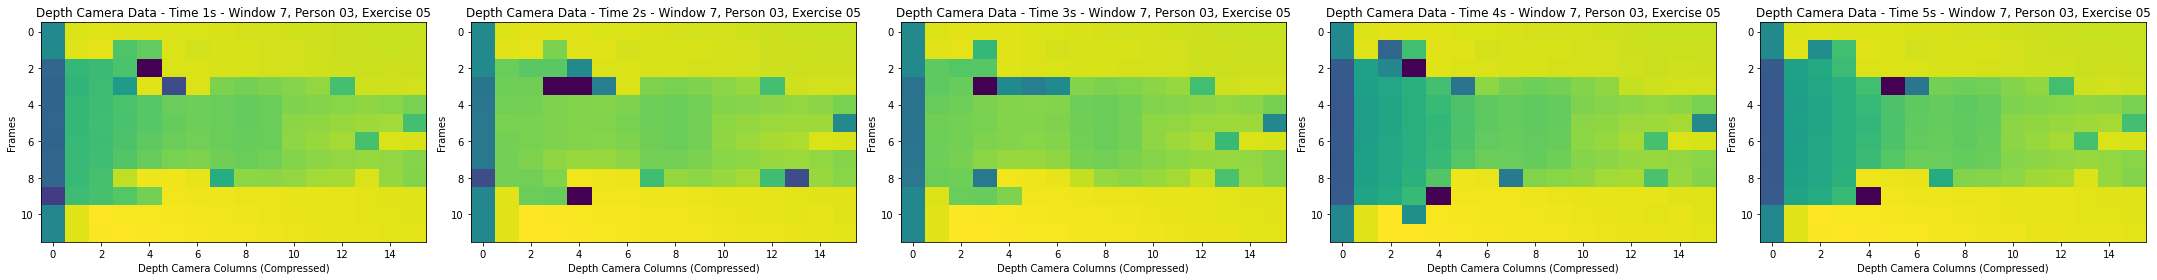

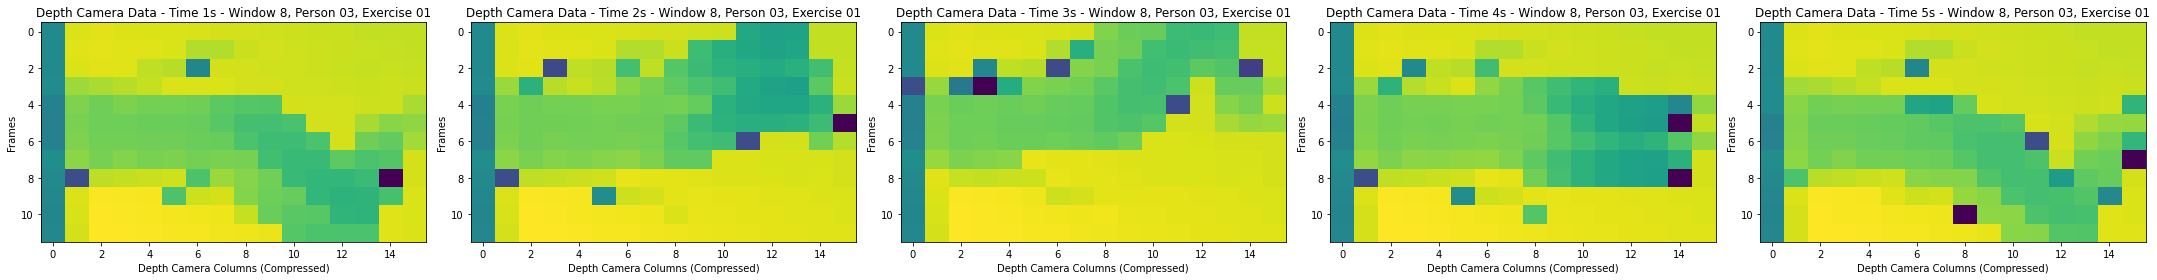

In [7]:

def plot_dc_values(dc_windows):
    """
    Plots the depth camera values for each window in the given DataFrame.

    Parameters:
    dc_windows (DataFrame): DataFrame containing the depth camera windows.

    Returns:
    None
    """    
    for _, dc_window in dc_windows.iterrows():
        selected_row = deepcopy(dc_window['df'])
        
        if 'time' in selected_row.columns:
            selected_row.drop(columns=['time'], inplace=True)
            
        dc_values_all_rows = np.array([row.to_numpy() for _, row in selected_row.iterrows()]).reshape(-1, 12, 16, 1)
        
        fig, axs = plt.subplots(1, len(dc_values_all_rows), figsize=(6 * len(dc_values_all_rows), 4))

        for i in range(len(dc_values_all_rows)):
            # Plotting in the subplot
            axs[i].imshow(dc_values_all_rows[i], cmap='viridis', aspect='auto')
            axs[i].set_title(f'Depth Camera Data - Time {i + 1}s - Window {dc_window["window_idx"]}, Person {dc_window["subject_id"]}, Exercise {dc_window["exercise_id"]}')
            axs[i].set_xlabel('Depth Camera Columns (Compressed)')
            axs[i].set_ylabel('Frames')

        # Adjust layout to prevent clipping of titles and labels
        plt.tight_layout()
        plt.show()

# generate dc_values_all_rows and plot the depth camera data
rows_to_plot = [29, 45]
plot_dc_values(dc_data.iloc[rows_to_plot])

Plot of 5 second depth image sequences of person 1 and 5 performing exercises 2, 5, and 6

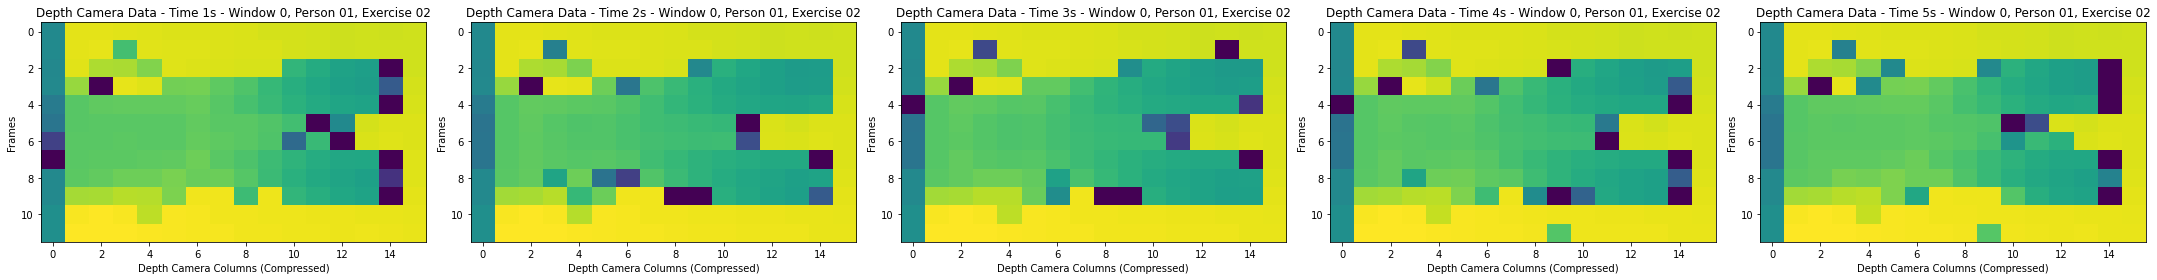

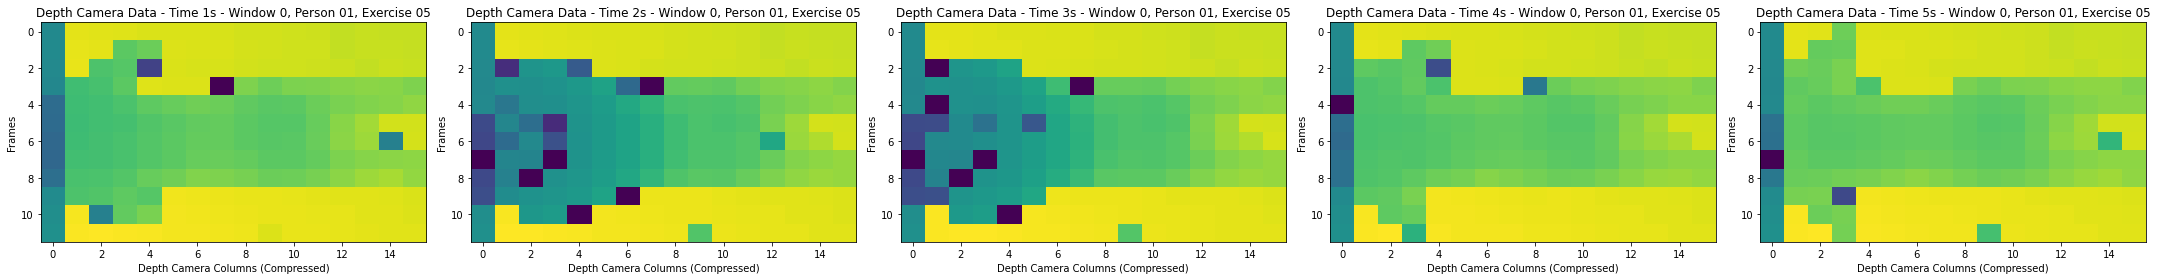

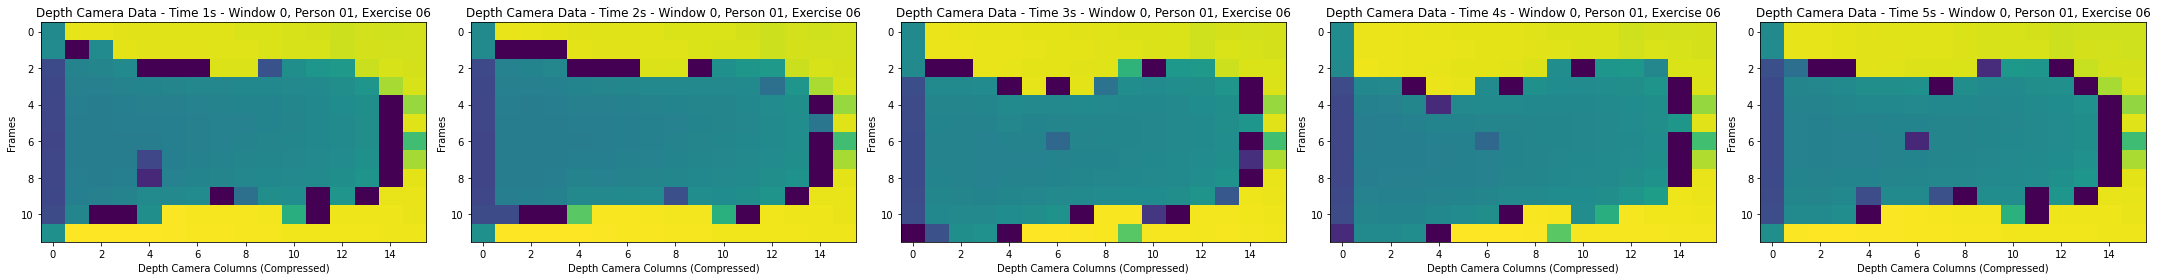

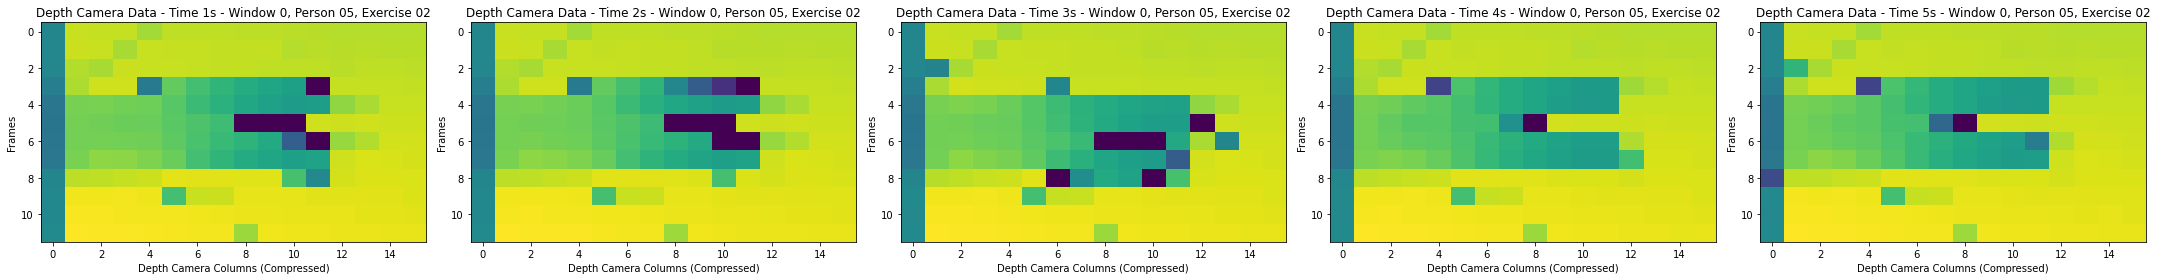

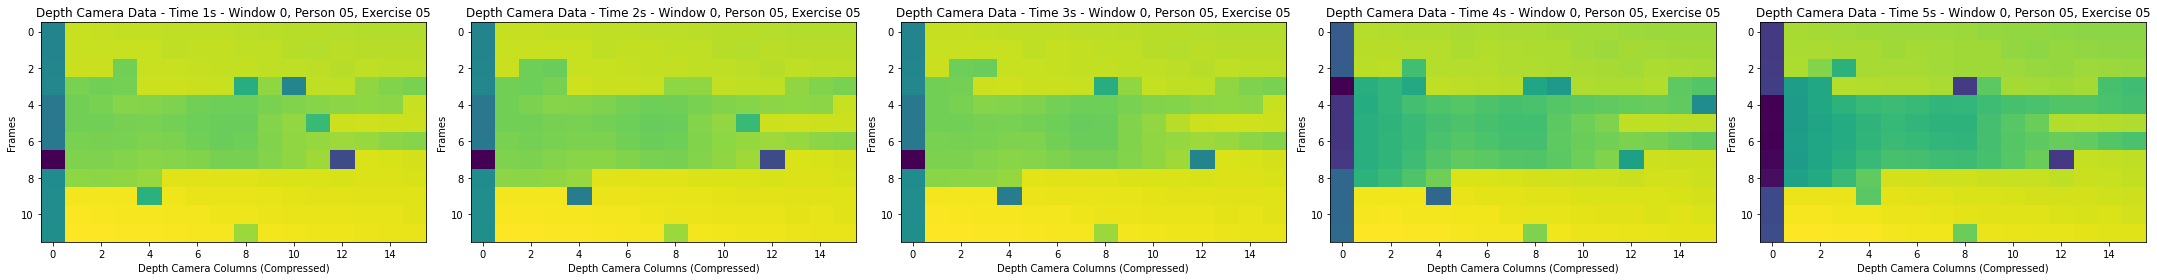

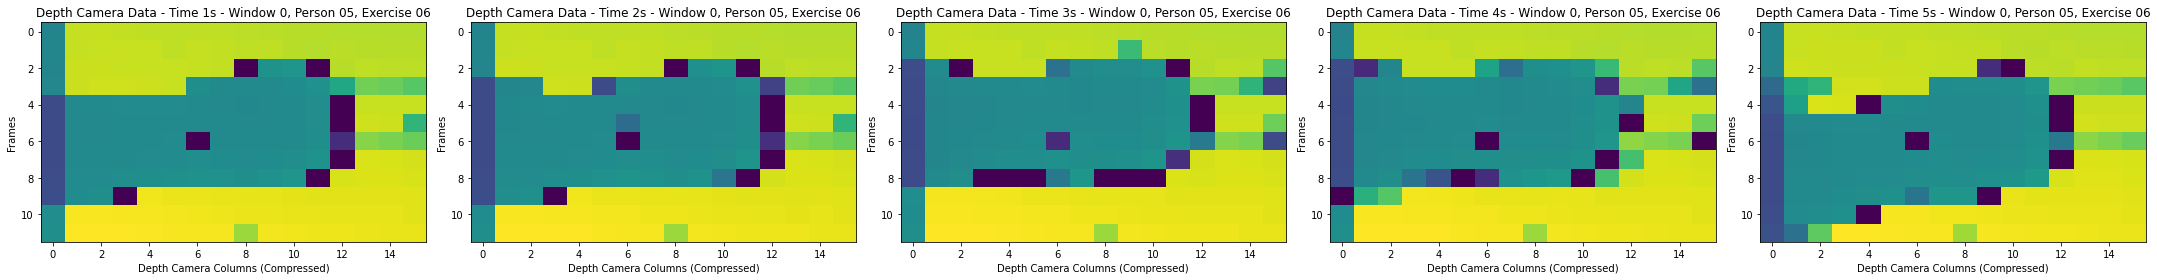

In [8]:
subject_id = ['01', '05']
exercise_id = ['02', '05', '06']
data_to_plot = []
for subject in subject_id:
    for exercise in exercise_id:
        data_to_plot.append(dc_data[(dc_data['subject_id'] == subject) & (dc_data['exercise_id'] == exercise)].iloc[0])

acc_df = pd.DataFrame(data_to_plot)
titles_list = [f'Accelerometer Data\nPerson {row["subject_id"]}, Exercise {row["exercise_id"]}, Window {row["window_idx"]}' for row in data_to_plot]

plot_dc_values(acc_df)

## Data preprocessing

<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [9]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

### Your code begins here ###

training_set =  df_records_windowed[df_records_windowed["subject_id"].isin([str(i).zfill(2) for i in range(1, 8)])]
testing_set =  df_records_windowed[df_records_windowed["subject_id"].isin([str(i).zfill(2) for i in range(8, 11)])]

training_acc = deepcopy(training_set[training_set['sensor'] == 'acc'])
training_dc = deepcopy(training_set[training_set['sensor'] == 'dc'])

testing_acc = deepcopy(testing_set[testing_set['sensor'] == 'acc'])
testing_dc = deepcopy(testing_set[testing_set['sensor'] == 'dc'])

#Dropping the accelaration data that does not have a corresponding dc data
compare_columns = ['subject_id', 'exercise_id', 'trial', 'window_idx']
merged_df = pd.merge(training_acc, training_dc, how='outer', on=compare_columns, indicator=True)
training_acc = training_acc.drop(merged_df[merged_df['_merge'] == 'left_only'].index, axis=0)

# Dropping the dc data that does not have a corresponding accelaration data
training_acc['df'] = training_acc['df'].apply(lambda x: x.drop(columns=['time']))
testing_acc['df'] = testing_acc['df'].apply(lambda x: x.drop(columns=['time']))

training_dc['df'] = training_dc['df'].apply(lambda x: x.drop(columns=['time']))
testing_dc['df'] = testing_dc['df'].apply(lambda x: x.drop(columns=['time']))

# Indicator statistics for training set
training_stats = {
    'acc_examples': len(training_acc),
    'dc_examples': len(training_dc),
    'acc_dimensions': training_acc.shape,  
    'dc_dimensions': training_dc.shape,
    'acc_df_example': training_acc.iloc[0]['df'].shape,
    'dc_df_example': training_dc.iloc[0]['df'].shape
}

# Indicator statistics for testing set
testing_stats = {
    'acc_examples': len(testing_acc),
    'dc_examples': len(testing_dc),
    'acc_dimensions': testing_acc.shape,  
    'dc_dimensions': testing_dc.shape,
    'acc_df_example': testing_acc.iloc[0]['df'].shape,
    'dc_df_example': testing_dc.iloc[0]['df'].shape
}

# Displaying indicator statistics
print("Training Set Statistics:")
print(training_stats)
print("\nTesting Set Statistics:")
print(testing_stats)

### Your code ends here ###

Training Set Statistics:
{'acc_examples': 1486, 'dc_examples': 1486, 'acc_dimensions': (1486, 7), 'dc_dimensions': (1486, 7), 'acc_df_example': (500, 3), 'dc_df_example': (5, 192)}

Testing Set Statistics:
{'acc_examples': 598, 'dc_examples': 598, 'acc_dimensions': (598, 7), 'dc_dimensions': (598, 7), 'acc_df_example': (500, 3), 'dc_df_example': (5, 192)}


Merging the matching accelaration data and depth camera 

In [10]:
compare_columns = ['subject_id', 'exercise_id', 'trial', 'window_idx']
merged_train = pd.merge(training_acc, training_dc, how='outer', on=compare_columns, indicator=True)
merged_test = pd.merge(testing_acc, testing_dc, how='outer', on=compare_columns, indicator=True)

print('Merged Training Set:')
display(merged_train)
print('Merged Testing Set:')
display(merged_test)

Merged Training Set:


,subject_id,exercise_id,trial,sensor_code_x,sensor_x,df_x,window_idx,sensor_code_y,sensor_y,df_y,_merge
0,03,02,1,act,acc,acc_0 acc_1 acc_2 0 -0.76562...,0,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both
1,03,02,1,act,acc,acc_0 acc_1 acc_2 200 -0.70312...,1,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both
2,03,02,1,act,acc,acc_0 acc_1 acc_2 400 -0.46875...,2,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both
3,03,02,1,act,acc,acc_0 acc_1 acc_2 600 -0.500...,3,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
4,03,02,1,act,acc,acc_0 acc_1 acc_2 800 -0.500...,4,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
...,...,...,...,...,...,...,...,...,...,...,...
1481,06,05,1,act,acc,acc_0 acc_1 acc_2 3400 0.796...,17,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
1482,06,05,1,act,acc,acc_0 acc_1 acc_2 3600 0.796...,18,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
1483,06,05,1,act,acc,acc_0 acc_1 acc_2 3800 0.796...,19,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
1484,06,05,1,act,acc,acc_0 acc_1 acc_2 4000 0.781...,20,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both


Merged Testing Set:


,subject_id,exercise_id,trial,sensor_code_x,sensor_x,df_x,window_idx,sensor_code_y,sensor_y,df_y,_merge
0,10,02,1,act,acc,acc_0 acc_1 acc_2 0 0.65625...,0,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
1,10,02,1,act,acc,acc_0 acc_1 acc_2 200 0.65625...,1,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
2,10,02,1,act,acc,acc_0 acc_1 acc_2 400 0.50000...,2,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 d...,both
3,10,02,1,act,acc,acc_0 acc_1 acc_2 600 0.546...,3,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 ...,both
4,10,02,1,act,acc,acc_0 acc_1 acc_2 800 0.640...,4,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 ...,both
...,...,...,...,...,...,...,...,...,...,...,...
593,08,03,1,act,acc,acc_0 acc_1 acc_2 4600 -0.553...,23,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both
594,08,03,1,act,acc,acc_0 acc_1 acc_2 4800 -0.484...,24,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both
595,08,03,1,act,acc,acc_0 acc_1 acc_2 5000 -0.468...,25,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both
596,08,03,1,act,acc,acc_0 acc_1 acc_2 5200 -0.484...,26,dc,dc,dc_0 dc_1 dc_2 dc_3 dc_4 dc...,both


# 2. Feature extraction and fusion for unimodal classification

#### Common functions

Function for preprocessing the data. standardizing and downsampling the data(only for acc) before applying transformations 

In [11]:
### Your code begins here ###
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

def resample_scale(data, orig_freq, new_freq):
    # Resample the data
    new_num_points = int(len(data) * new_freq / orig_freq)
    preprocess_data = resample(data, new_num_points).reshape(-1, 1)
    
    return preprocess_data.flatten()

def preprocess(df, columns, resample=True):
    combined_features = []
    for col in columns:
        preprocessed_data = df.apply(lambda x: x[col].values)
        
        # resample the data to 25 Hz
        if resample:
            preprocessed_data = df.apply(lambda x: resample_scale(data=x[col].values, orig_freq=100, new_freq=25))
        preprocessed_data = np.vstack(preprocessed_data.values)
        
        # Standardize the data
        scaler = StandardScaler()
        preprocessed_data = scaler.fit_transform(preprocessed_data)

        # Add the preprocessed data to the list
        combined_features.append(preprocessed_data)

    return np.stack(combined_features, axis=1)

Function for fitting PCA with 5-dimensional subspace and fitting LDA with 5-dimensional subspace.

In [12]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def transform_data_with_pca_lda(X_train, X_test, y_train, n_components=5):
    X_train_transform_pca = np.zeros((X_train.shape[0], X_train.shape[1], n_components))
    X_test_transform_pca = np.zeros((X_test.shape[0], X_test.shape[1], n_components))

    X_train_transform_lda = np.zeros((X_train.shape[0], X_train.shape[1], n_components))
    X_test_transform_lda = np.zeros((X_test.shape[0], X_test.shape[1], n_components))

    for i in range(X_train.shape[1]):
        # Apply PCA
        pca = PCA(n_components=n_components)

        # Fit and transform on the training set
        f_train = pca.fit_transform(X_train[:, i, :])
        X_train_transform_pca[:, i, :] = f_train
        
        # Transform the test set using the parameters learned from the training set
        f_test = pca.transform(X_test[:, i, :])
        X_test_transform_pca[:, i, :] = f_test  

        # Apply LDA
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        
        # Fit and transform on the training set
        f_train_lda = lda.fit_transform(X_train[:, i, :], y_train)
        X_train_transform_lda[:, i, :] = f_train_lda
        
        # Transform the test set using the parameters learned from the training set
        f_test_lda = lda.transform(X_test[:, i, :])
        X_test_transform_lda[:, i, :] = f_test_lda

    return X_train_transform_pca, X_test_transform_pca, X_train_transform_lda, X_test_transform_lda

#### Fusion of LDA and PCA subspaces

Projection onto PCA and LDA Subspaces

Training Variables:

- Training examples in PCA subspace:
  - $ \Theta_n = \hat{\beta}_{0n} + \sum \limits _{j=1} ^{K} X_{jn}\hat{\beta}_{jn} $

- Training examples in LDA subspace:
  - $ \Phi_n = \hat{\beta}_{0n} + \sum \limits _{j=1} ^{K} X_{jn}\hat{\beta}_{jn} $

Testing Variables:

- Test example in PCA subspace:
  - $ \theta = \hat{\beta}_{0} + \sum \limits _{j=1} ^{K} X_{j}\hat{\beta}_{j} $

- Test example in LDA subspace:
  - $ \phi = \hat{\beta}_{0} + \sum \limits _{j=1} ^{K} X_{j}\hat{\beta}_{j} $

Computing Euclidean Distances

- Compute Euclidean distances between the test example and training examples in PCA ($ \theta $ and $ \Theta_n $) and LDA ($ \phi $ and $ \Phi_n $) projected subspaces:
  - $ d_n = \sum_{k=1}^{K} (\theta(k) - \Theta_n(k))^2 $
  - $ D_n = \sum_{k=1}^{K} (\phi(k) - \Phi_n(k))^2 $

Normalization

- Normalize values between 0 and 1:
  - $ d_n = \frac{d_n - \min_m(d_m)}{\max_m(d_m) - \min_m(d_m)} $
  - $ D_n = \frac{D_n - \min_m(D_m)}{\max_m(D_m) - \min_m(D_m)} $

Fusion by Averaging

- Fuse by averaging (arithmetic mean):
  - $ F_n = \frac{1}{2} (d_n + D_n) $

Classification

- Classify the test example as belonging to the class of the $ n^{th} $ training example (i.e., the nearest neighbor):
  - $ n^* = \arg\min_n $


In [13]:
# Function to fuse PCA and LDA and classify
def fuse_pca_lda_classification(test_example_pca, test_example_lda, training_examples_pca, training_examples_lda):

    # Initialize distances
    pca_distances = np.sum((test_example_pca - training_examples_pca) ** 2, axis=(1))
    lda_distances = np.sum((test_example_lda - training_examples_lda) ** 2, axis=(1))

    # Normalize distances between 0 and 1
    min_pca_dist, max_pca_dist = min(pca_distances), max(pca_distances)
    min_lda_dist, max_lda_dist = min(lda_distances), max(lda_distances)

    normalized_pca_distances = (pca_distances - min_pca_dist) / (max_pca_dist - min_pca_dist)
    normalized_lda_distances = (lda_distances - min_lda_dist) / (max_lda_dist - min_lda_dist)

    # Fuse by averaging (arithmetic mean)
    fusion_scores = 0.5 * (normalized_pca_distances + normalized_lda_distances)

    # Classify test example as belonging to the class of the nearest neighbor
    predicted_window = np.argmin(fusion_scores)

    return predicted_window

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as 
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

Preprocessing and Keeping the processed data seperately for future reference

In [14]:
merged_train['preprocessed_data_acc'] = [_ for _ in preprocess(df=merged_train['df_x'], columns=['acc_0', 'acc_1', 'acc_2'], resample=True)]
merged_test['preprocessed_data_acc'] = [_ for _ in preprocess(df=merged_test['df_x'], columns=['acc_0', 'acc_1', 'acc_2'] , resample=True)]

Preparing processed training ans testing set before applying transformation

In [15]:
X_train_acc = np.stack(merged_train['preprocessed_data_acc'].values)
y_train_acc = merged_train['exercise_id'].values

X_test_acc = np.stack(merged_test['preprocessed_data_acc'].values)
y_test_acc = merged_test['exercise_id'].values

print(f'X_train shape: {X_train_acc.shape}\ny_train shape: {y_train_acc.shape}\nX_test shape: {X_test_acc.shape}\ny_test shape: {y_test_acc.shape}')

X_train shape: (1486, 3, 125)
y_train shape: (1486,)
X_test shape: (598, 3, 125)
y_test shape: (598,)


Converting the accelorometer data to PCA and LDA subspaces and forms data of size ***n_samples x 3 x 5*** and reshaping it a single feature vector of size ***n_samples x 15***. 

In [16]:
X_train_pca, X_test_pca, X_train_lda, X_test_lda = transform_data_with_pca_lda(X_train_acc, X_test_acc, y_train_acc, n_components=5)
print('Shape of the transformed data:')
print(f'X_train_pca shape: {X_train_pca.shape}\nX_test_pca shape: {X_test_pca.shape}\nX_train_lda shape: {X_train_lda.shape}\nX_test_lda shape: {X_test_lda.shape}')

# Reshape the data to create the feature vectors
X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], -1)
X_test_pca = X_test_pca.reshape(X_test_pca.shape[0], -1)
X_train_lda = X_train_lda.reshape(X_train_lda.shape[0], -1)
X_test_lda = X_test_lda.reshape(X_test_lda.shape[0], -1)

print('\nShape of the feature vectors after reshaping:')
print(f'X_train_pca shape: {X_train_pca.shape}\nX_test_pca shape: {X_test_pca.shape}\nX_train_lda shape: {X_train_lda.shape}\nX_test_lda shape: {X_test_lda.shape}')

Shape of the transformed data:
X_train_pca shape: (1486, 3, 5)
X_test_pca shape: (598, 3, 5)
X_train_lda shape: (1486, 3, 5)
X_test_lda shape: (598, 3, 5)

Shape of the feature vectors after reshaping:
X_train_pca shape: (1486, 15)
X_test_pca shape: (598, 15)
X_train_lda shape: (1486, 15)
X_test_lda shape: (598, 15)


Applying fusion of PCA and LDA to classify the test examples. F1 Score and the confusion matrix is plotted.

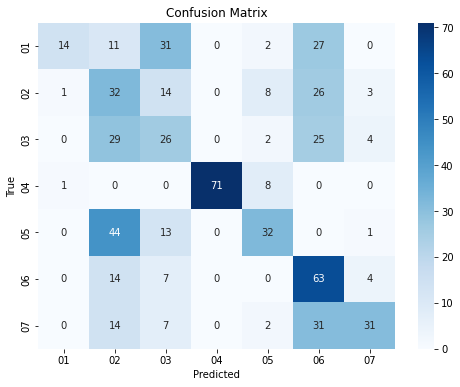

F1 Score: 0.46


In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = []
for x_test_pca, x_test_lda in zip(X_test_pca, X_test_lda):
    pred_idx = fuse_pca_lda_classification(x_test_pca, x_test_lda, X_train_pca, X_train_lda)
    predictions.append(y_train_acc[pred_idx])

f1_score = f1_score(y_test_acc, predictions, average='macro')
cm = confusion_matrix(y_test_acc, predictions, labels=np.unique(y_test_acc))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_acc), yticklabels=np.unique(y_test_acc))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'F1 Score: {f1_score:.2f}')
# your code ends here

**Analysis:** The F1 Score of 0.46 suggests that the model's performance is moderate in terms of precision and recall. The confusion matrix provides additional insights. It appears that the model is struggling with certain classes, particularly with classifying samples into categories 0, 1, 2, 5, and 7. The model performs relatively well in distinguishing class 4, achieving a high precision score, which indicates that the instances it classifies as class 4 are likely correct. However, the results also show room for improvement.

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

Preprocessing and Keeping the processed data seperately for future reference

In [18]:
### Your code begins here ###
dc_columns = list(merged_train.iloc[0]['df_y'].columns)

merged_train['preprocessed_data_dc'] = [_.T for _ in preprocess(df=merged_train['df_y'], columns=dc_columns, resample=False)]
merged_test['preprocessed_data_dc'] = [_.T for _ in preprocess(df=merged_test['df_y'], columns=dc_columns, resample=False)]

Preparing processed training ans testing set before applying transformation

In [19]:
X_train_dc = np.stack(merged_train['preprocessed_data_dc'] .values)
y_train_dc = merged_train['exercise_id'].values

X_test_dc = np.stack(merged_test['preprocessed_data_dc'] .values)
y_test_dc = merged_test['exercise_id'].values

print(f'X_train shape: {X_train_dc.shape}\ny_train shape: {y_train_dc.shape}\nX_test shape: {X_test_dc.shape}\ny_test shape: {y_test_dc.shape}')

X_train shape: (1486, 5, 192)
y_train shape: (1486,)
X_test shape: (598, 5, 192)
y_test shape: (598,)


Converting the depth camera data to PCA and LDA subspaces and forms data of size ***n_samples x 5 x 5*** and reshaping it a single feature vector of size ***n_samples x 25***. 

In [20]:
X_train_pca, X_test_pca, X_train_lda, X_test_lda = transform_data_with_pca_lda(X_train_dc, X_test_dc, y_train_dc, n_components=5)
print('Shape of the transformed data:')
print(f'X_train_pca shape: {X_train_pca.shape}\nX_test_pca shape: {X_test_pca.shape}\nX_train_lda shape: {X_train_lda.shape}\nX_test_lda shape: {X_test_lda.shape}')

# Reshape the data to create the feature vectors
X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], -1)
X_test_pca = X_test_pca.reshape(X_test_pca.shape[0], -1)
X_train_lda = X_train_lda.reshape(X_train_lda.shape[0], -1)
X_test_lda = X_test_lda.reshape(X_test_lda.shape[0], -1)

print('\nShape of the feature vectors after reshaping:')
print(f'X_train_pca shape: {X_train_pca.shape}\nX_test_pca shape: {X_test_pca.shape}\nX_train_lda shape: {X_train_lda.shape}\nX_test_lda shape: {X_test_lda.shape}')

Shape of the transformed data:
X_train_pca shape: (1486, 5, 5)
X_test_pca shape: (598, 5, 5)
X_train_lda shape: (1486, 5, 5)
X_test_lda shape: (598, 5, 5)

Shape of the feature vectors after reshaping:
X_train_pca shape: (1486, 25)
X_test_pca shape: (598, 25)
X_train_lda shape: (1486, 25)
X_test_lda shape: (598, 25)


Applying fusion of PCA and LDA to classify the test examples. F1 Score and the confusion matrix is plotted.

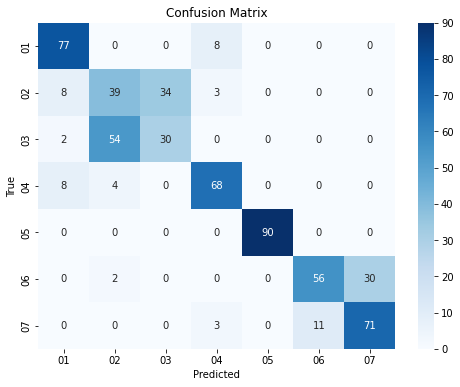

F1 Score: 0.72


In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = []
for x_test_pca, x_test_lda in zip(X_test_pca, X_test_lda):
    pred_idx = fuse_pca_lda_classification(x_test_pca, x_test_lda, X_train_pca, X_train_lda)
    predictions.append(y_train_dc[pred_idx])

f1_score = f1_score(y_test_dc, predictions, average='macro')
cm = confusion_matrix(y_test_dc, predictions, labels=np.unique(y_test_dc))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_dc), yticklabels=np.unique(y_test_dc))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'F1 Score: {f1_score:.2f}')
# your code ends here

**Analysis:** The F1 Score of 0.72 indicates a relatively good overall performance for the model in classifying data from the depth camera. The confusion matrix further supports this, revealing high diagonal values, especially along the main diagonal, indicating correct classifications. The model excels in distinguishing class 5, achieving a high precision and recall, suggesting that it effectively identifies instances belonging to this category. However, there are some challenges in differentiating classes 2, 3, and 6, as indicated by the non-zero off-diagonal values in these rows. Fine-tuning the model or exploring additional features could potentially address these challenges and further improve the classification performance. Overall, the results indicate a robust performance, but there may be room for optimization in handling specific classes.

# 3. Feature extraction and feature-level fusion for multimodal classification

Function to calculate PCA

In [22]:
### Your code begins here ###
from sklearn.decomposition import PCA

def transform_data_with_pca(X_train, X_test, n_components=10):
    X_train_transform_pca = np.zeros((X_train.shape[0], X_train.shape[1], n_components))
    X_test_transform_pca = np.zeros((X_test.shape[0], X_test.shape[1], n_components))
    
    for i in range(X_train.shape[1]):
        # Apply PCA
        pca = PCA(n_components=n_components)

        # Fit and transform on the training set
        f_train = pca.fit_transform(X_train[:, i, :])
        X_train_transform_pca[:, i, :] = f_train
        
        # Transform the test set using the parameters learned from the training set
        f_test = pca.transform(X_test[:, i, :])
        X_test_transform_pca[:, i, :] = f_test  

    return X_train_transform_pca, X_test_transform_pca

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as 
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

Preparing processed training ans testing set before applying transformation

In [23]:
# 3.1
X_train_acc = np.stack(merged_train['preprocessed_data_acc'].values)
y_train_acc = merged_train['exercise_id'].values

X_test_acc = np.stack(merged_test['preprocessed_data_acc'].values)
y_test_acc = merged_test['exercise_id'].values

print('ACC Train and test data shapes:')
print(f'X_train shape: {X_train_acc.shape}\ny_train shape: {y_train_acc.shape}\n\nX_test shape: {X_test_acc.shape}\ny_test shape: {y_test_acc.shape}')

ACC Train and test data shapes:
X_train shape: (1486, 3, 125)
y_train shape: (1486,)

X_test shape: (598, 3, 125)
y_test shape: (598,)


Converting the accelarator data to PCA subspaces and forms data of size ***n_samples x 3 x 10***. Then calculates the statistical features including mean and std for three acc channels and combine those with the reshaped feature vector and forms 36 dimensional feature vector of size ***n_samples x 36***. 

In [24]:
X_train_pca, X_test_pca = transform_data_with_pca(X_train_acc, X_test_acc, n_components=10)

print('Shape of the transformed ACC data:')
print(f'X_train_pca shape: {X_train_pca.shape}\nX_test_pca shape: {X_test_pca.shape}')

# Calculate mean and standard deviation of the training set
mean_train = np.mean(X_train_pca, axis=2)
std_train = np.std(X_train_pca, axis=2)

# Calculate mean and standard deviation of the test set
mean_test = np.mean(X_test_pca, axis=2)
std_test = np.std(X_test_pca, axis=2)

# Reshape the data to create the feature vectors
X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], -1)
X_test_pca = X_test_pca.reshape(X_test_pca.shape[0], -1)

X_train_acc = np.concatenate((X_train_pca, mean_train, std_train), axis=1)  
X_test_acc = np.concatenate((X_test_pca, mean_test, std_test), axis=1)  

print('\nShape of the transformed ACC data with statiscal features:')
print(f'X_train_pca shape: {X_train_acc.shape}\nX_test_pca shape: {X_test_acc.shape}')
### Your code ends here ###

Shape of the transformed ACC data:
X_train_pca shape: (1486, 3, 10)
X_test_pca shape: (598, 3, 10)

Shape of the transformed ACC data with statiscal features:
X_train_pca shape: (1486, 36)
X_test_pca shape: (598, 36)


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

Similarly, preparing processed training and testing set for depth camera

In [25]:
# 3.2

### Your code begins here ###
X_train_dc = np.stack(merged_train['preprocessed_data_dc'].values)
y_train_dc = merged_train['exercise_id'].values

X_test_dc = np.stack(merged_test['preprocessed_data_dc'].values)
y_test_dc = merged_test['exercise_id'].values

print('DC Train and test data shapes:')
print(f'X_train shape: {X_train_dc.shape}\ny_train shape: {y_train_dc.shape}\n\nX_test shape: {X_test_dc.shape}\ny_test shape: {y_test_dc.shape}')


DC Train and test data shapes:
X_train shape: (1486, 5, 192)
y_train shape: (1486,)

X_test shape: (598, 5, 192)
y_test shape: (598,)


Converting the depth camera data to PCA subspaces and forms data of size ***n_samples x 5 x 10***. Then reshaped feature vector and forms 50 dimensional feature vector of size ***n_samples x 50***. 

In [26]:
X_train_pca, X_test_pca = transform_data_with_pca(X_train_dc, X_test_dc, n_components=10)
print('Shape of the transformed data:')
print(f'X_train_pca shape: {X_train_pca.shape}\nX_test_pca shape: {X_test_pca.shape}\n')

# Reshape the data to create the feature vectors
X_train_dc = X_train_pca.reshape(X_train_pca.shape[0], -1)
X_test_dc = X_test_pca.reshape(X_test_pca.shape[0], -1)

print('Shape of the transformed DC data:')
print(f'X_train_pca shape: {X_train_dc.shape}\nX_test_pca shape: {X_test_dc.shape}')
### Your code ends here ###

Shape of the transformed data:
X_train_pca shape: (1486, 5, 10)
X_test_pca shape: (598, 5, 10)

Shape of the transformed DC data:
X_train_pca shape: (1486, 50)
X_test_pca shape: (598, 50)


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

Join the feature vectors from depth images and the accelarator data and form a combine feature vector of size ***n_sample x 86***. Then normalzie the data by training MinMaxScaler on training set and applying it on both training and testing datasets. 

In [27]:
# 3.3

### Your code begins here ###
from sklearn.preprocessing import MinMaxScaler

X_train = np.concatenate((X_train_acc, X_train_dc), axis=1)  
X_test = np.concatenate((X_test_acc, X_test_dc), axis=1)

y_train = merged_train['exercise_id'].values
y_test = merged_test['exercise_id'].values

print('Shape of the fused data:')
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape},\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

# Normalize the data between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Shape of the fused data:
X_train shape: (1486, 86)
X_test shape: (598, 86),
y_train shape: (1486,)
y_test shape: (598,)


Training two different machine learning models, Support Vector Machine (SVM) and Gaussian Naive Bayes, to make predictions on the test dataset. After training, the code evaluates how well each model performs by creating confusion matrices, which show how many predictions were correct or incorrect for each class. The F1 score is also calculated, providing a single number to understand overall performance. 

Support Vector Machine (SVM) Results:
Confusion Matrix:


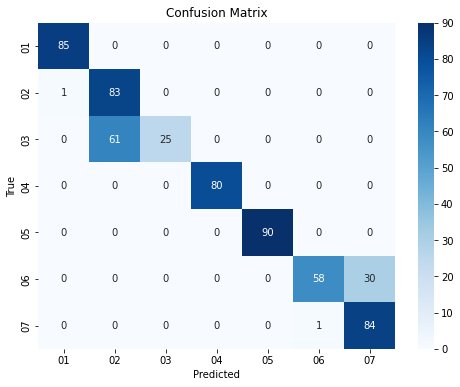

F1 Score: 0.83


Gaussian Naive Bayes Results:
Confusion Matrix:


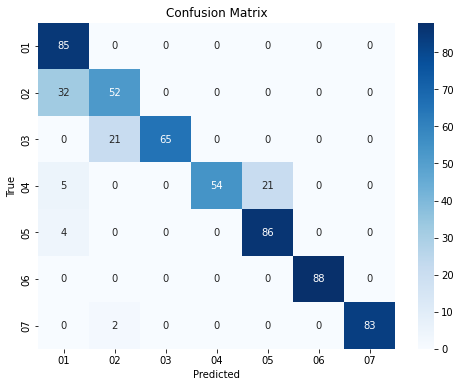

F1 Score: 0.86




In [28]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, f1_score

# Support Vector Machine (SVM) with RBF Kernel
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)  # Assuming y_train is your target variable

# Predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

# Evaluate SVM
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_f1_score = f1_score(y_test, svm_predictions, average='macro')

# Gaussian Naive Bayes
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)  # Assuming y_train is your target variable

# Predictions on the test set
gnb_predictions = gnb_classifier.predict(X_test)

# Evaluate Gaussian Naive Bayes
gnb_conf_matrix = confusion_matrix(y_test, gnb_predictions)
gnb_f1_score = f1_score(y_test, gnb_predictions, average='macro')

# Print results
print("Support Vector Machine (SVM) Results:")
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(f'F1 Score: {svm_f1_score:.2f}')
print("\n")

print("Gaussian Naive Bayes Results:")
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(gnb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(f'F1 Score: {gnb_f1_score:.2f}')
print("\n")
### Your code ends here ###

**Analysis:** 
For the first result with an F1 Score of 0.83 achieved by the SVM classifier, the confusion matrix indicates high accuracy across all classes, as evidenced by the dominant diagonal values. This suggests that the model performs well in correctly classifying instances for each category. The model exhibits excellent precision and recall, particularly notable for classes 1, 4, 5, and 6. Overall, the SVM classifier demonstrates strong performance and reliability in distinguishing between different classes.

For the second result with an F1 Score of 0.86 obtained using Gaussian Naive Bayes, the confusion matrix shows a robust performance as well. The model excels in classifying instances for all categories, as indicated by high diagonal values. Notably, it achieves high precision and recall for classes 1, 5, 6, and 7. However, there are some misclassifications evident in classes 2, 3 and 4, where false positives and false negatives are observed. Despite these minor challenges, the Gaussian Naive Bayes classifier demonstrates overall excellent performance with a high F1 Score, particularly in distinguishing specific classes.

In summary, both models showcase strong capabilities in classifying instances, with the SVM model performing admirably across all classes, and the Gaussian Naive Bayes model excelling with high precision and recall in certain categories. 

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as 
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

Preparing the feature set prepared for previous task 

In [29]:
# 4.1

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

### Your code begins here ###

# Features calculated in Task 3
print('Shape of the transformed ACC data:')
print(f'X_train_acc shape: {X_train_acc.shape}, X_test_acc shape: {X_test_acc.shape}')

print('\nShape of the transformed DC data:')
print(f'X_train_dc shape: {X_train_dc.shape}, X_test_dc shape: {X_test_dc.shape}')

print('\nShape of class labels:')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')


Shape of the transformed ACC data:
X_train_acc shape: (1486, 36), X_test_acc shape: (598, 36)

Shape of the transformed DC data:
X_train_dc shape: (1486, 50), X_test_dc shape: (598, 50)

Shape of class labels:
y_train shape: (1486,), y_test shape: (598,)


Normalizing the data using train set 

In [30]:
# Normalize the data along each axis
scaler_acc = MinMaxScaler()
X_train_acc_normalized = scaler_acc.fit_transform(X_train_acc)
X_test_acc_normalized = scaler_acc.transform(X_test_acc)

scaler_dc = MinMaxScaler()
X_train_dc_normalized = scaler_dc.fit_transform(X_train_dc)
X_test_dc_normalized = scaler_dc.transform(X_test_dc)

Training the SVM and Ada-boost base classifiers by tuning model-parameters using cross-validated grid-search over a parameter grid and find the optimal set of parameters.

In [31]:
# Define parameter grids for grid search
param_grid_svm = {'C': [0.1, 1.0, 10.0, 100.0], 'gamma': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
param_grid_adaboost = {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]}

# Train SVM and AdaBoost classifiers
# Base Classifier 1: SVM
svm_classifier_acc = SVC(kernel='rbf')
grid_search_svm_acc = GridSearchCV(svm_classifier_acc, param_grid_svm, cv=10, n_jobs=-1, scoring='f1_macro')
grid_search_svm_acc.fit(X_train_acc_normalized, y_train)
best_params_svm_acc = grid_search_svm_acc.best_params_

svm_classifier_dc = SVC(kernel='rbf')
grid_search_svm_dc = GridSearchCV(svm_classifier_dc, param_grid_svm, cv=10, n_jobs=-1, scoring='f1_macro')
grid_search_svm_dc.fit(X_train_dc_normalized, y_train)
best_params_svm_dc = grid_search_svm_dc.best_params_

# Base Classifier 2: AdaBoost
adaboost_classifier_acc = AdaBoostClassifier(random_state=0)
grid_search_adaboost_acc = GridSearchCV(adaboost_classifier_acc, param_grid_adaboost, cv=10, n_jobs=-1, scoring='f1_macro')
grid_search_adaboost_acc.fit(X_train_acc_normalized, y_train)
best_params_adaboost_acc = grid_search_adaboost_acc.best_params_

adaboost_classifier_dc = AdaBoostClassifier(random_state=0)
grid_search_adaboost_dc = GridSearchCV(adaboost_classifier_dc, param_grid_adaboost, cv=10, n_jobs=-1, scoring='f1_macro')
grid_search_adaboost_dc.fit(X_train_dc_normalized, y_train)
best_params_adaboost_dc = grid_search_adaboost_dc.best_params_


In [32]:
# Print best parameters
print("Best parameters for SVM with ACC data:", best_params_svm_acc)
print("Best parameters for SVM with DC data:", best_params_svm_dc)
print("Best parameters for AdaBoost with ACC data:", best_params_adaboost_acc)
print("Best parameters for AdaBoost with DC data:", best_params_adaboost_dc)

Best parameters for SVM with ACC data: {'C': 100.0, 'gamma': 2.0}
Best parameters for SVM with DC data: {'C': 10.0, 'gamma': 0.25}
Best parameters for AdaBoost with ACC data: {'learning_rate': 0.5, 'n_estimators': 1000}
Best parameters for AdaBoost with DC data: {'learning_rate': 0.75, 'n_estimators': 1000}


 Choosing the best parameters and train the classifiers for each modality on whole training dataset.

In [33]:
# Train classifiers with the best parameters
final_svm_acc = SVC(kernel='rbf', **best_params_svm_acc, probability=True)
final_svm_acc.fit(X_train_acc_normalized, y_train)

final_svm_dc = SVC(kernel='rbf', **best_params_svm_dc, probability=True)
final_svm_dc.fit(X_train_dc_normalized, y_train)

final_adaboost_acc = AdaBoostClassifier(**best_params_adaboost_acc, random_state=0)
final_adaboost_acc.fit(X_train_acc_normalized, y_train)

final_adaboost_dc = AdaBoostClassifier(**best_params_adaboost_dc, random_state=0)
final_adaboost_dc.fit(X_train_dc_normalized, y_train)

AdaBoostClassifier(learning_rate=0.75, n_estimators=1000, random_state=0)

Evaluating and calculating the scores for each model for each modality


SVM (ACC) F1 Score: 0.5176732173763381
SVM (DC) F1 Score: 0.8532602503504298
AdaBoost (ACC) F1 Score: 0.6607844430599703
AdaBoost (DC) F1 Score: 0.4553971538013733


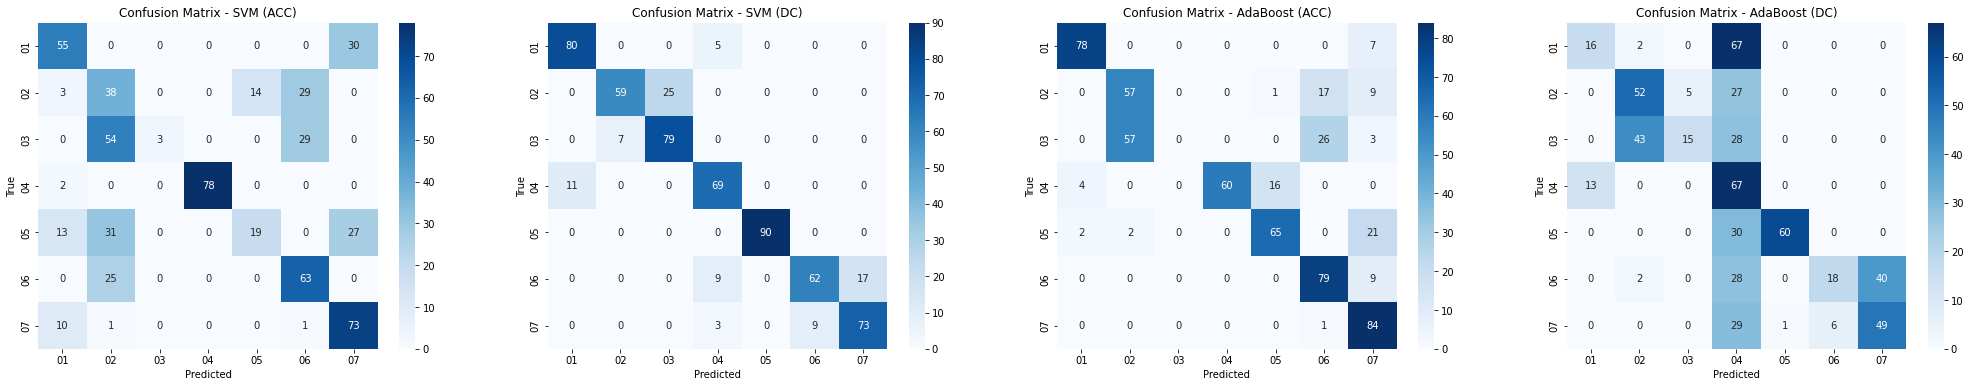

In [34]:
# Evaluate classifiers on the testing dataset
svm_acc_predictions = final_svm_acc.predict(X_test_acc_normalized)
svm_dc_predictions = final_svm_dc.predict(X_test_dc_normalized)

adaboost_acc_predictions = final_adaboost_acc.predict(X_test_acc_normalized)
adaboost_dc_predictions = final_adaboost_dc.predict(X_test_dc_normalized)

# Calculate F1 scores
f1_score_svm_acc = f1_score(y_test, svm_acc_predictions, average='macro')
f1_score_svm_dc = f1_score(y_test, svm_dc_predictions, average='macro')
f1_score_adaboost_acc = f1_score(y_test, adaboost_acc_predictions, average='macro')
f1_score_adaboost_dc = f1_score(y_test, adaboost_dc_predictions, average='macro')

# Calculate confusion matrices
confusion_matrix_svm_acc = confusion_matrix(y_test, svm_acc_predictions)
confusion_matrix_svm_dc = confusion_matrix(y_test, svm_dc_predictions)
confusion_matrix_adaboost_acc = confusion_matrix(y_test, adaboost_acc_predictions)
confusion_matrix_adaboost_dc = confusion_matrix(y_test, adaboost_dc_predictions)

print("\nSVM (ACC) F1 Score:", f1_score_svm_acc)
print("SVM (DC) F1 Score:", f1_score_svm_dc)
print("AdaBoost (ACC) F1 Score:", f1_score_adaboost_acc)
print("AdaBoost (DC) F1 Score:", f1_score_adaboost_dc)

fig, axs = plt.subplots(1, 4, figsize=(35, 6))

models = ['SVM (ACC)', 'SVM (DC)', 'AdaBoost (ACC)', 'AdaBoost (DC)']
confusion_matrices = [confusion_matrix_svm_acc, confusion_matrix_svm_dc, confusion_matrix_adaboost_acc, confusion_matrix_adaboost_dc]

for i in range(4):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=axs[i])
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    axs[i].set_title(f'Confusion Matrix - {models[i]}')

plt.show()

**Analysis:** 
The F1 Scores for the Support Vector Machine (SVM) and AdaBoost classifiers on accelerometer (ACC) and depth camera (DC) data showcase interesting patterns. For the accelerometer data, the SVM achieves a relatively lower F1 Score of 0.52, indicating moderate precision and recall. However, the SVM significantly outperforms on the depth camera data with a high F1 Score of 0.85, suggesting excellent precision and recall, particularly in distinguishing between different classes. On the other hand, AdaBoost exhibits a higher F1 Score of 0.66 for accelerometer data but a lower F1 Score of 0.46 for depth camera data. These results imply that the choice of classifier has a notable impact on performance across different sensor modalities. 

<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

Predicts the probabilistic outputs for SVM classifiers and AdaBoost classifiers on the test data for each modality.

In [48]:
# 4.2
# Predict probabilistic outputs for SVM classifiers
svm_acc_proba = final_svm_acc.predict_proba(X_test_acc_normalized)
svm_dc_proba = final_svm_dc.predict_proba(X_test_dc_normalized)
adaboost_acc_proba = final_adaboost_acc.predict_proba(X_test_acc_normalized)
adaboost_dc_proba = final_adaboost_dc.predict_proba(X_test_dc_normalized)

Sample 1 in the test set: 02
Sample 2 in the test set: 02


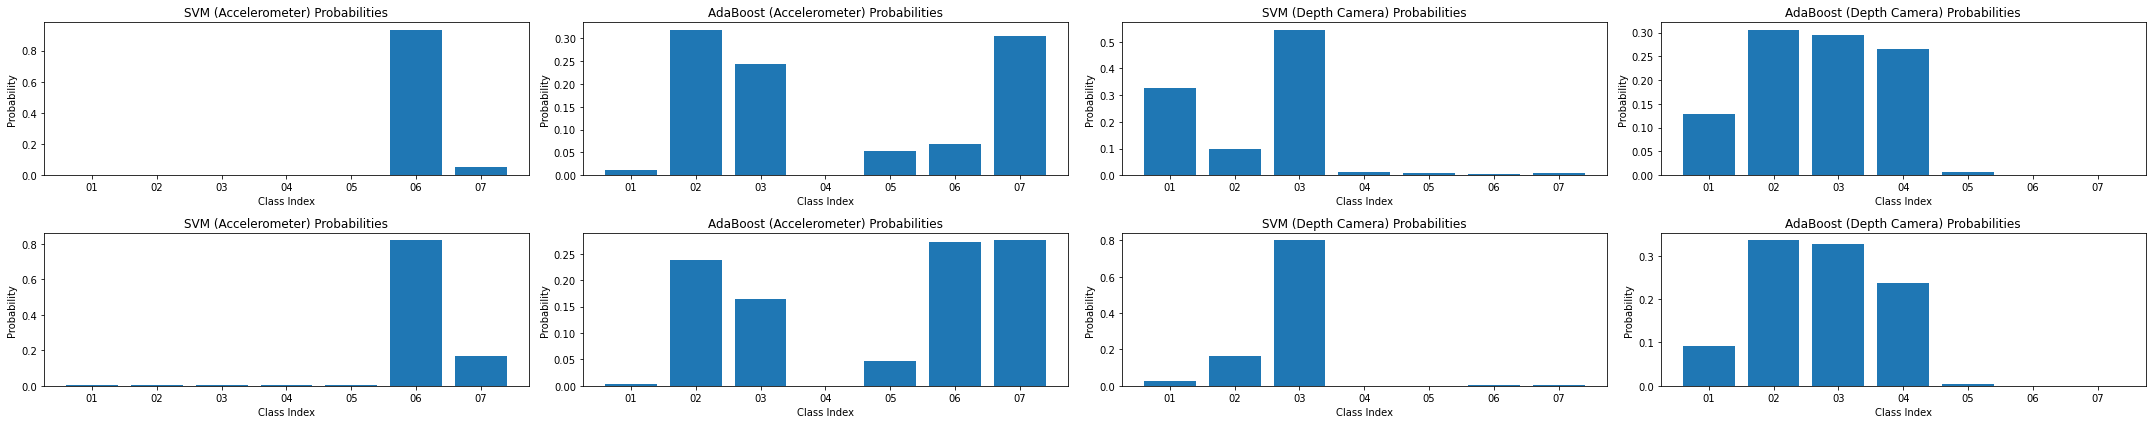

In [49]:
def plot_proba(probabilities, title, subplot_index):
    plt.subplot(2, 4, subplot_index)
    plt.bar(final_svm_acc.classes_, probabilities, align='center')
    plt.title(title)
    plt.xlabel('Class Index')
    plt.ylabel('Probability')

plt.figure(figsize=(30, 6))
# Plot predicted probabilities for the first two samples in the test set
for i in range(2):
    print(f"Sample {i+1} in the test set:", y_test[i])
    
    # Plot SVM probabilities for accelerometer modality
    plot_proba(svm_acc_proba[i], 'SVM (Accelerometer) Probabilities', i*4 + 1)

    # Plot AdaBoost probabilities for accelerometer modality
    plot_proba(adaboost_acc_proba[i], 'AdaBoost (Accelerometer) Probabilities', i*4 + 2)

    # Plot SVM probabilities for direct current modality
    plot_proba(svm_dc_proba[i], 'SVM (Depth Camera) Probabilities', i*4 + 3)

    # Plot AdaBoost probabilities for direct current modality
    plot_proba(adaboost_dc_proba[i], 'AdaBoost (Depth Camera) Probabilities', i*4 + 4)

plt.tight_layout()
plt.show()

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

Combining the trained clasiffier probability prediction for each class by using fixed classification rules of max, min, prod and sum

In [57]:
y_test_idx = np.array([int(i) for i in y_test])

posterior_scores_svm_acc_svm_dc = np.array((svm_acc_proba, svm_dc_proba))
posterior_scores_adaboost_acc_adaboost_dc = np.array((adaboost_acc_proba, adaboost_dc_proba))
posterior_scores_svm_acc_adaboost_dc = np.array((svm_acc_proba, adaboost_dc_proba))
posterior_scores_adaboost_acc_svm_dc = np.array((adaboost_acc_proba, svm_dc_proba))


print("Posterior scores for SVM (ACC) and SVM (DC):", posterior_scores_svm_acc_svm_dc.shape)
print("Posterior scores for AdaBoost (ACC) and AdaBoost (DC):", posterior_scores_adaboost_acc_adaboost_dc.shape)
print("Posterior scores for SVM (ACC) and AdaBoost (DC):", posterior_scores_svm_acc_adaboost_dc.shape)
print("Posterior scores for AdaBoost (ACC) and SVM (DC):", posterior_scores_adaboost_acc_svm_dc.shape)

Posterior scores for SVM (ACC) and SVM (DC): (2, 598, 7)
Posterior scores for AdaBoost (ACC) and AdaBoost (DC): (2, 598, 7)
Posterior scores for SVM (ACC) and AdaBoost (DC): (2, 598, 7)
Posterior scores for AdaBoost (ACC) and SVM (DC): (2, 598, 7)


Calculating the f1-score and the confusion matrix for each combined classifier results. 

Combinations are -  $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$
The seleted four classification rules are applied for each combination

F1 Score for SVM (ACC) and SVM (DC) with max: 0.72011836784355
F1 Score for SVM (ACC) and SVM (DC) with min: 0.8401581654996374
F1 Score for SVM (ACC) and SVM (DC) with product: 0.8752354862966837
F1 Score for SVM (ACC) and SVM (DC) with sum: 0.7499955657708073
F1 Score for AdaBoost (ACC) and AdaBoost (DC) with max: 0.6781704218665868
F1 Score for AdaBoost (ACC) and AdaBoost (DC) with min: 0.7088481794738863
F1 Score for AdaBoost (ACC) and AdaBoost (DC) with product: 0.7029429951046332
F1 Score for AdaBoost (ACC) and AdaBoost (DC) with sum: 0.7628748763494718
F1 Score for SVM (ACC) and AdaBoost (DC) with max: 0.5742424353539898
F1 Score for SVM (ACC) and AdaBoost (DC) with min: 0.693399056161158
F1 Score for SVM (ACC) and AdaBoost (DC) with product: 0.7458795765616072
F1 Score for SVM (ACC) and AdaBoost (DC) with sum: 0.6292957270595542
F1 Score for AdaBoost (ACC) and SVM (DC) with max: 0.8880691972528921
F1 Score for AdaBoost (ACC) and SVM (DC) with min: 0.9189105031308866
F1 Score fo

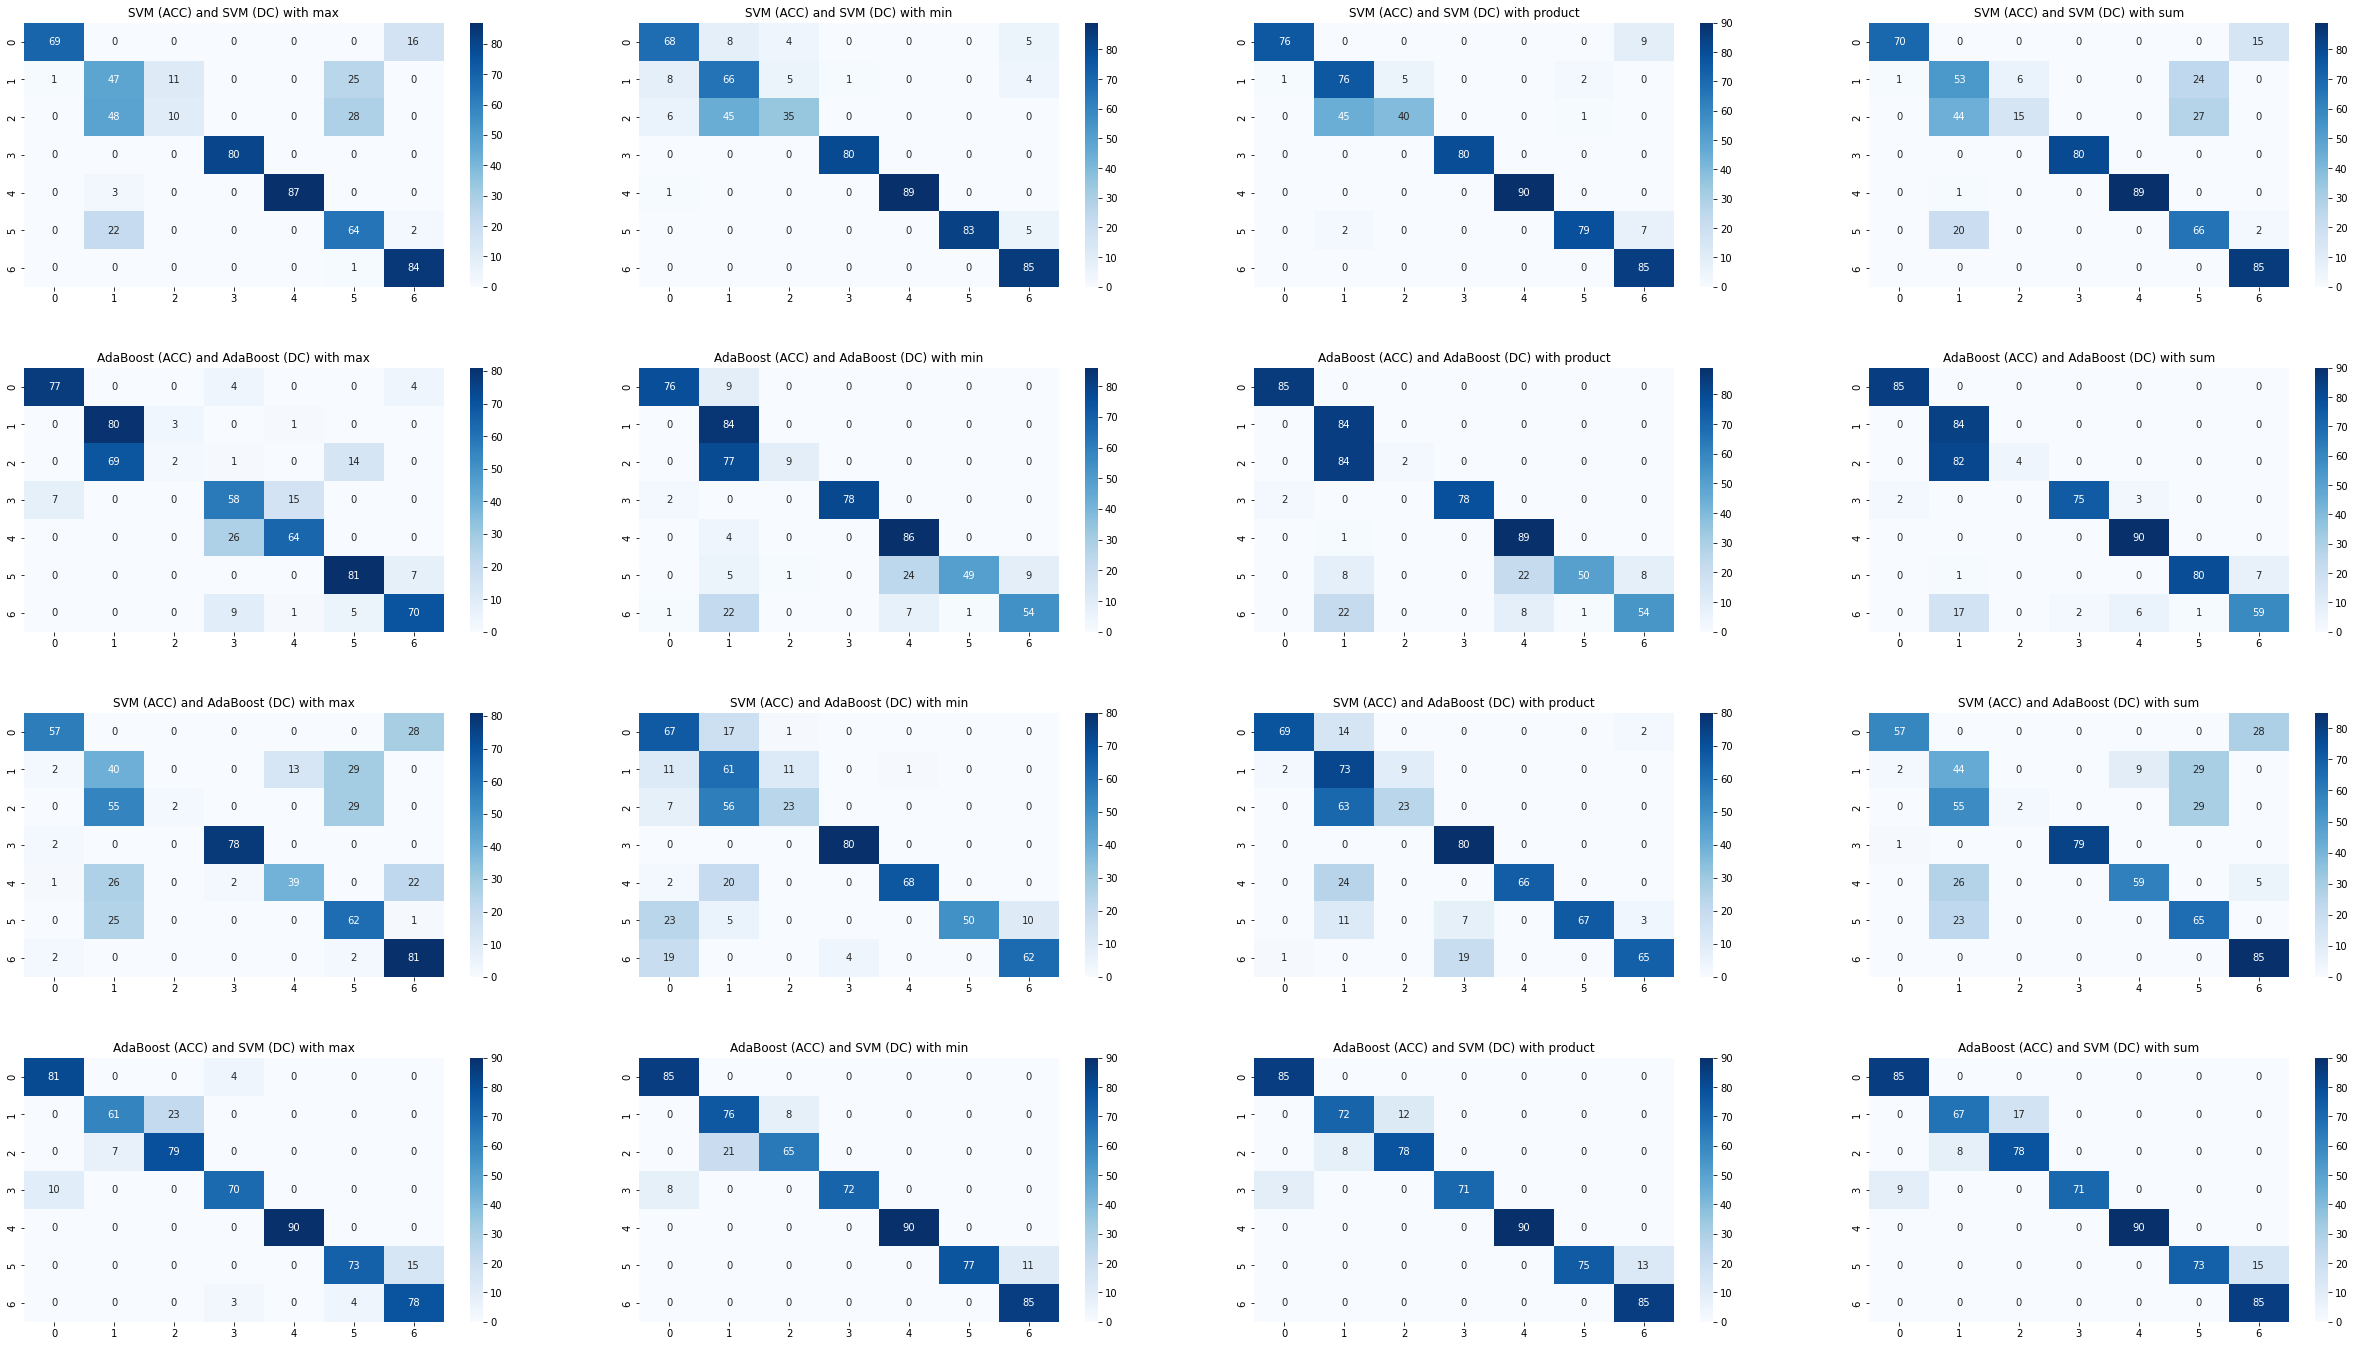

In [71]:
results = {
    "SVM (ACC) and SVM (DC) with max": np.argmax(np.max(posterior_scores_svm_acc_svm_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and SVM (DC) with min": np.argmax(np.min(posterior_scores_svm_acc_svm_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and SVM (DC) with product": np.argmax(np.prod(posterior_scores_svm_acc_svm_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and SVM (DC) with sum": np.argmax(np.sum(posterior_scores_svm_acc_svm_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and AdaBoost (DC) with max": np.argmax(np.max(posterior_scores_adaboost_acc_adaboost_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and AdaBoost (DC) with min": np.argmax(np.min(posterior_scores_adaboost_acc_adaboost_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and AdaBoost (DC) with product": np.argmax(np.prod(posterior_scores_adaboost_acc_adaboost_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and AdaBoost (DC) with sum": np.argmax(np.sum(posterior_scores_adaboost_acc_adaboost_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and AdaBoost (DC) with max": np.argmax(np.max(posterior_scores_svm_acc_adaboost_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and AdaBoost (DC) with min": np.argmax(np.min(posterior_scores_svm_acc_adaboost_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and AdaBoost (DC) with product": np.argmax(np.prod(posterior_scores_svm_acc_adaboost_dc, axis=0), axis=1) + 1,
    "SVM (ACC) and AdaBoost (DC) with sum": np.argmax(np.sum(posterior_scores_svm_acc_adaboost_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and SVM (DC) with max": np.argmax(np.max(posterior_scores_adaboost_acc_svm_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and SVM (DC) with min": np.argmax(np.min(posterior_scores_adaboost_acc_svm_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and SVM (DC) with product": np.argmax(np.prod(posterior_scores_adaboost_acc_svm_dc, axis=0), axis=1) + 1,
    "AdaBoost (ACC) and SVM (DC) with sum": np.argmax(np.sum(posterior_scores_adaboost_acc_svm_dc, axis=0), axis=1) + 1
}

for title, predictions in results.items():
    f1 = f1_score(y_test_idx, predictions, average='macro')
    print(f"F1 Score for {title}: {f1}")

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(35, 20))
fig.tight_layout(pad=6.0)

# Loop through results and plot confusion matrices
for i, (title, score) in enumerate(results.items()):
    cm = confusion_matrix(y_test_idx, score)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(title)

plt.show()

**Analysis:** The F1 scores provide a comprehensive evaluation of the performance of different combinations of models and aggregation methods on the given dataset. Notably, the combination of AdaBoost with the SVM model trained on the depth camera (AdaBoost (ACC) and SVM (DC)) consistently demonstrates the highest F1 scores across all aggregation methods (max, min, product, sum), indicating robust and effective classification performance. Conversely, SVM (ACC) and AdaBoost (DC) exhibit comparatively lower F1 scores, suggesting a less optimal fusion of information from accelerometer and depth camera modalities. Interestingly, SVM (ACC) and SVM (DC) with product aggregation show strong performance, indicating that the multiplication operation enhances discriminative power.

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [39]:
# 5.1

### Your code begins here ###

### Your code ends here ###

<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [40]:
# 5.2

### Your code begins here ###

### Your code ends here ###